## Please insert some parameters
* the name of the source 

In [ ]:
source = 'Cen X-3'


### Imports

In [1]:
import hratio
import numpy as np
from astropy.table import Table
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.stats import norm
import shutil
import os, sys
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord
from importlib import reload
from astropy.io import fits as pf

 INFO - generated new fontManager


## Importing modules developed for this project:
* nustarpipeline process to wrap the nustar analysis for our needs
* nustarpipeline utils to collect useful functions
* pyxmmsas (originally for XMM) for spectral fitting


In [2]:
os.environ['HEADAS']='/opt/heasoft/x86_64-pc-linux-gnu-libc2.31'
os.system('. ${HEADAS}/headas-init.sh')
os.system('export PFILES="/tmp$$.tmp/pfiles;$HEADAS/syspfiles"')

0

In [3]:
from nustarpipeline import process, utils
import pyxmmsas as pysas

## This is the spectral analysis.
* First find a suitable model for your source, running xspec iteratively and save the model only, use the file as input mod_file below
* the routine below provides a file files.xcm to start with a basic model called mod_base.xcm
* compute the MCMC to get eror and corner plots
* at a second iteration, you can just load the chain (comment and uncomment the lines starting with load_chain=...)
* the chain commands are to create a script to be lunched externally and need to be tuned for the correct parameter number

### load spectra and and a basic model in pyxspec

Using output file basename GW-mod_base-
We load 2 spectra
['**-3.0,70.0-**', '**-3.0,70.0-**']

***Warning: The file sent to Xset.restore(): mod_base.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Creating a $HOME/.xspec directory for you
   All chains are now removed.
Resetting constants for fit
jeffreys prior for TBabs nH
jeffreys prior for highecut cutoffE

2 spectra  in use
 
Spectral Data File: FPMA_sr_rbn.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.462e+01 +/- 5.501e-02 (99.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-2440
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 2.143e+04 sec
 Using fit statistic: chi
 Using Background File                FPMA_bk.pha
  Background Exposure Time: 2.143e+04 sec
 Using Response (RMF) File            FPMA_sr.rmf for Source 1
 Usi

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
PGPLOT /png: writing new file as GW-mod_base-euf_plot.png_2


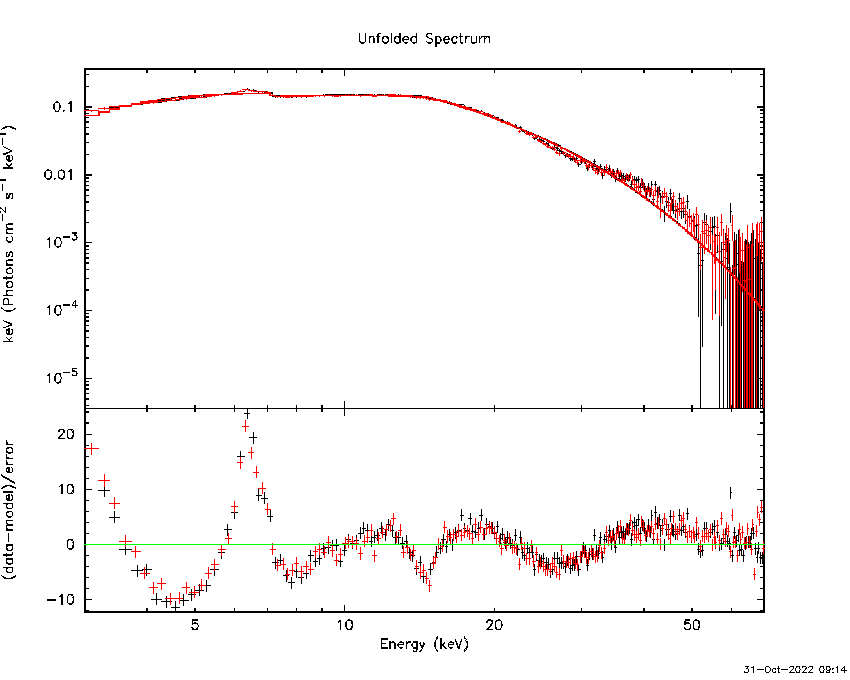

0 with 431 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                 3731.79     using 217 bins.
                 C-Statistic                 3463.35     using 220 bins.
Total fit statistic                          7262.04     with 431 d.o.f.
   (Includes a Bayesian contribution of 33.45)

Test statistic : Chi-Squared                 6974.62     using 437 bins.
 Null hypothesis probability of 0.00e+00 with 431 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                 3731.79     using 217 bins.
                 C-Statistic                 3463.35     using 220 bins.
Total fit statistic                          7300.06     with 431 d.o.f.
   (Includes a Bayesian contribution of 52.46)

Test statistic : Chi-Squared                 6974.62     using 437 bins.
 Null hypothesis probability of 0.00e+00 with 431 degrees of freedom
 Current data and model not fit yet.
***Warning: Fit is not current.
Fit Sta

In [4]:
import xspec
os.chdir('/home/jovyan/work/ap-lab-i-2022/data/')

#use the base model
mod_file = 'mod_base.xcm'

#The following is an attempt to plot the model without the cyclotron lines
#mod_file = 'mod_3gabs_zero.xcm'



outputfiles_basename = 'GW-%s-' % (mod_file.replace('../mod_', '').replace('.xcm',''))

#'bxa-run-model.xcm'
pn_spec="FPMA_sr_rbn.pi"
mos1_spec="FPMB_sr_rbn.pi"
mos2_spec="none"
ignore_string=['**-3.0,70.0-**']*2
print("Using output file basename " + outputfiles_basename)


load_chain=False
compute_errors=False
perform_fit=False
save_xcm=False
run_chain=False

chain_name, fit_res =pysas.epic_xspec_mcmc_fit(xspec, mod_file, 
                                outputfiles_basename = outputfiles_basename,
                                pn_spec = pn_spec,
                                mos1_spec = mos1_spec,
                                mos2_spec =mos2_spec, 
                                jeffreys_priors=['norm', 'nH', 'cutoffE', 'foldE'],
                                               #jeffreys_priors=['norm', 'nH', 'T0', 'kT', 'taup'],
                                ignore_string=ignore_string,
                                load_chain=load_chain, perform_fit=perform_fit, set_priors=True, walkers=60, 
                                               run_chain=run_chain,
                                               compute_errors=compute_errors, save_xcm=save_xcm )


## We make a fit with a more complex model

Using output file basename GW-mod_pcfabs_2gauss_2gabs-
We load 2 spectra
['**-3.0,70.0-**', '**-3.0,70.0-**']
   All chains are now removed.

2 spectra  in use
 
Spectral Data File: FPMA_sr_rbn.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.462e+01 +/- 5.501e-02 (99.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-2440
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 2.143e+04 sec
 Using fit statistic: cstat
 Using Background File                FPMA_bk.pha
  Background Exposure Time: 2.143e+04 sec
 Using Response (RMF) File            FPMA_sr.rmf for Source 1
 Using Auxiliary Response (ARF) File  FPMA_sr.arf

Spectral Data File: FPMB_sr_rbn.pi  Spectrum 2
Net count rate (cts/s) for Spectrum:2  6.067e+01 +/- 5.310e-02 (99.9 % total)
 Assigned to Data Group 2 and Plot Group 2
  Noticed Channels:  1-2442
  Telescope: NuSTAR Instrument: FPMB  Channel Type: PI
  Exposure Time: 2.158e+04 sec
 Using fit statistic: cstat
 Using Backg

PGPLOT /png: writing new file as GW-mod_pcfabs_2gauss_2gabs-euf_plot.png_2


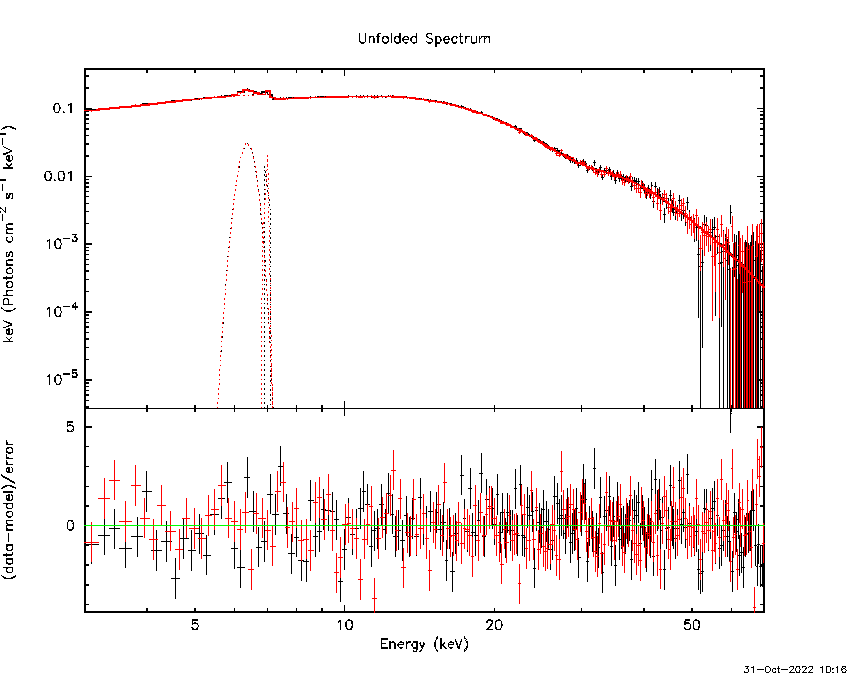

                                   Parameters
C-Statistic  |beta|/N    Lvl          1:nH          2:nH    3:CvrFract       4:LineE       5:Sigma    6:Strength       7:LineE       8:Sigma    9:Strength    10:cutoffE      11:foldE      12:LineE      13:Sigma       14:norm       20:norm   21:PhoIndex       24:norm       48:norm
527.262      0.631541      6       2.28593       38.4724      0.556415       29.0651       4.53326       4.72604       14.5002      0.677627      0.133464       14.4238       9.18821       6.35587      0.186989    0.00312184   0.000587298       1.31137       13735.8       13647.7
 Variances and Principal Axes
                 1        2        3        4        5        6        7        8        9       10       11       12       13       14       20       21       24       48  
 1.8525E-09|  0.0003   0.0001   0.0105   0.0000  -0.0000   0.0000  -0.0000   0.0000   0.0000  -0.0000  -0.0000  -0.0020  -0.0011  -0.2589  -0.9654  -0.0283  -0.0000  -0.0000  
 4.1431E-09|

In [5]:
import xspec

run_chain = True
reload(pysas)
fit_by_bin={}

chains=[]
#mod_file=outputfiles_basename+'model.xcm'
#mod_file='../model_cut.xcm'
    
mod_file = 'mod_pcfabs_2gauss_2gabs.xcm'


outputfiles_basename = 'GW-%s-' % (mod_file.replace('../mod_', '').replace('.xcm',''))

#'bxa-run-model.xcm'
pn_spec="FPMA_sr_rbn.pi"
mos1_spec="FPMB_sr_rbn.pi"
mos2_spec="none"
ignore_string=['**-3.0,70.0-**']*2
print("Using output file basename " + outputfiles_basename)


if run_chain:
    load_chain=False
    compute_errors=True
    perform_fit=True
    save_xcm=True
else:
    load_chain=True
    compute_errors=True
    perform_fit=False
    save_xcm=False
    
    
chain_name, fit_res =pysas.epic_xspec_mcmc_fit(xspec, mod_file, 
                                outputfiles_basename = outputfiles_basename,
                                pn_spec = pn_spec,
                                mos1_spec = mos1_spec,
                                mos2_spec =mos2_spec, 
                                jeffreys_priors=['norm', 'nH', 'cutoffE', 'foldE'],
                                               #jeffreys_priors=['norm', 'nH', 'T0', 'kT', 'taup'],
                                ignore_string=ignore_string,
                                load_chain=load_chain, perform_fit=perform_fit, set_priors=True, walkers=60, 
                                               run_chain=run_chain,
                                               compute_errors=compute_errors, save_xcm=save_xcm, 
                                               burn=8000, runLength=64000, )
chains.append(chain_name)


chain_commands='''

chain clear
chain type gw
chain walkers 60
chain burn 26000
chain length 36000

bayes on
bayes 1 jeffreys
bayes 8 jeffreys
bayes 9 jeffreys
bayes 12 jeffreys
bayes 16 jeffreys
bayes 32 jeffreys
query yes
fit

chain proposal gaussian diagonal 1e-1 1e-5 0.2 0.5 0.1 10. 10.
chain run %schain.fits

quit
yes

'''%outputfiles_basename


exposure, tstart, tstop = pysas.get_spec_exp_times("FPMA_sr_rbn.pi")



#    break



In [ ]:
print(chain_name)

## This estimated the goodness of fit (it is long)

In [ ]:
if True:
   
    sorted_sampled_fit_statistics, best_fit_statistic, goodness = \
    pysas.goodness_from_chain(xspec, outputfiles_basename, n_sample=1000,
                            pn_spec=pn_spec,
                            mos1_spec=mos1_spec,
                            mos2_spec=mos2_spec,
                            ignore_string=ignore_string)
    ff=open(outputfiles_basename+'simul_test.txt','w')
    for x in sorted_sampled_fit_statistics:
        ff.write("%f\n" % x)
    ff.write("%f*\n" % best_fit_statistic)
    ff.close()
    os.chdir('..')
    plt.figure()
    plt.hist(sorted_sampled_fit_statistics, bins=20, label='Sample')
    plt.axvline(best_fit_statistic, color='red', label='Best fit')
    plt.xlabel('Test statistics')
    plt.ylabel('Simulations')
    plt.legend()
    

## Please edit the next cell to display parameters of your model

In [86]:
latex_label_dict=pysas.default_latex_label_dict.copy()
print(latex_label_dict)
E_i=0
S_i=0
for j in fit_res.keys():
    if j=='rate':
        latex_label_dict.update({j:'Cts/s'})
    if j=='cstat':
        latex_label_dict.update({j:'$\chi^2_\\mathrm{red}$/d.o.f.'})
    if j=='nH
    if j[:4]=='LineE':
        if E_i==0:
            latex_label_dict.update({j:'$\E_\\mathrm{Fe}$'})
            E_i+=1
        elif E_i<=2:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc1}$'})
            E_i+=1
        elif 2<E_i<=4:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc2}$'})
            E_i+=1
        else:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc3}$'})
            E_i+=1
    if j[:4]=='Sigma':
        if S_i==0:
            latex_label_dict.update({j:'$\E_\\mathrm{Fe}$'})
            S_i+=1
        elif S_i<=2:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc1}$'})
            S_i+=1
        elif 2<S_i<=4:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc2}$'})
            S_i+=1
        else:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc3}$'})
            S_i+=1
            
                        
            
    


{'nH__02': '$n_\\mathrm{H}$', 'nH__03': '$n_\\mathrm{H, pc}$', 'CvrFract__04': 'Cov. Frac.', 'PhoIndex__05': '$\\Gamma$', 'norm__08': 'Flux (1-10 keV)', 'nH__2': '$n_\\mathrm{H}$', 'nH__3': '$n_\\mathrm{H, pc}$', 'CvrFract__4': 'Cov. Frac.', 'PhoIndex__5': '$\\Gamma$', 'norm__8': 'Flux (1-10 keV)', 'log(nH)__2': '$\\log(n_\\mathrm{H})$', 'log(nH)__3': '$\\log(n_\\mathrm{H, pc})$', 'log(norm)__8': '$\\log$(Flux (1-10 keV))', 'rate': 'Count Rate'}
rate
cstat
plot_filename
nH__01
nH__02
CvrFract__03
LineE__04
Sigma__05
Strength__06
LineE__07
Sigma__08
Strength__09
cutoffE__10
foldE__11
LineE__12
Sigma__13
norm__14
norm__20
PhoIndex__21
norm__24
norm__48


In [85]:
import pyxmmsas as pysas
latex_label_dict=pysas.default_latex_label_dict.copy()
latex_label_dict.update({ 
                        'nH__01': '$N_\\mathrm{H}$',
                        'nH__1': '$N_\\mathrm{H}$',                        
    'rate' : 'Cts/s',
    'cstat': '$\chi^2_\\mathrm{red}$/d.o.f.',
    
    'LineE__15': '$E_\\mathrm{Fe}$',
    'Sigma__16': '$\sigma_\\mathrm{Fe}$',
    'norm__17': '$N_\\mathrm{Fe}$',
    
    'LineE__2' : '$E_\\mathrm{Cyc1}$',
    'LineE__02' : '$E_\\mathrm{Cyc1}$',
    'Sigma__3' : '$\sigma_\\mathrm{Cyc1}$',
    'Sigma__03' : '$\sigma_\\mathrm{Cyc1}$',
    'Strength__4' : '$\\tau_\\mathrm{Cyc1}$',
    'Strength__04' : '$\\tau_\\mathrm{Cyc1}$',
    
    'LineE__5' : '$E_\\mathrm{Cyc2}$',
    'LineE__05' : '$E_\\mathrm{Cyc2}$',
    'Sigma__6' : '$\sigma_\\mathrm{Cyc2}$',
    'Sigma__06' : '$\sigma_\\mathrm{Cyc2}$',
    'Strength__7' : '$\\tau_\\mathrm{Cyc2}$',
    'Strength__07' : '$\\tau_\\mathrm{Cyc2}$',
    
    'LineE__8' : '$E_\\mathrm{Cyc3}$',
    'LineE__08' : '$E_\\mathrm{Cyc3}$',
    'Sigma__9' : '$\sigma_\\mathrm{Cyc3}$',
    'Sigma__09' : '$\sigma_\\mathrm{Cyc3}$',
    'Strength__10' : '$\\tau_\\mathrm{Cyc3}$',
    
    'cutoffE__11': '$E_\\mathrm{C}$',
    'foldE__12': '$E_\\mathrm{F}$',
    'kT__13': '$kT_\\mathrm{BB}$',
    'norm__14' : '$r^2_\\mathrm{BB}$',
        
     'norm__21': 'F [$10^{-12}$cgs]', #$_\mathrm{2-10 keV}$
    'norm__42': 'Flux (3-20 keV)',
    'PhoIndex__18': '$\\Gamma$',
})

In [116]:
import pyxmmsas as pysas
latex_label_dict=pysas.default_latex_label_dict.copy()
latex_label_dict.update({ 
    'nH__01': '$N_\\mathrm{H}$',
    'nH__02': '$N_\\mathrm{H}$',
    
    'CvrFract__03': 'Cov. Frac.', 
    
    'rate' : 'Cts/s',
    'cstat': '$\chi^2_\\mathrm{red}$/d.o.f.',
    
    'LineE__04': '$E_\\mathrm{Cyc1}$',
    'Sigma__05' : '$\sigma_\\mathrm{Cyc1}$',
    'Strength__06' : '$\\tau_\\mathrm{Cyc1}$',
    
    'LineE__07' : '$E_\\mathrm{Cyc2}$',
    'Sigma__08' : '$\sigma_\\mathrm{Cyc2}$',
    'Strength__09' : '$\\tau_\\mathrm{Cyc2}$',
    
    'cutoffE__10': '$E_\\mathrm{C}$',
    'foldE__11': '$E_\\mathrm{F}$',
    'LineE__12' : '$E_\\mathrm{Cyc3}$',
    'Sigma__13' : '$\sigma_\\mathrm{Cyc3}$',

    'PhoIndex__21': '$\\Gamma$',
    'norm__14' : 'F [$10^{-12}$cgs]',
    'norm__20' : 'F [$10^{-12}$cgs]',
    'norm__24' : 'F [$10^{-12}$cgs]', 
    'norm__48': 'Flux (3-20 keV)',
})

In [117]:
print(latex_label_dict.keys())

dict_keys(['nH__02', 'nH__03', 'CvrFract__04', 'PhoIndex__05', 'norm__08', 'nH__2', 'nH__3', 'CvrFract__4', 'PhoIndex__5', 'norm__8', 'log(nH)__2', 'log(nH)__3', 'log(norm)__8', 'rate', 'nH__01', 'nH__1', 'CvrFract__03', 'CvrFract__3', 'cstat', 'LineE__04', 'Sigma__05', 'Strength__06', 'LineE__07', 'Sigma__08', 'Strength__09', 'cutoffE__10', 'foldE__11', 'LineE__12', 'Sigma__13', 'PhoIndex__21', 'norm__14', 'norm__20', 'norm__24', 'norm__48'])


## Dump the latex table of parameters (you will need to make adjustements for the paper)

In [118]:
fit_res

{'rate': [63.24017059584069, 63.18577773099951, 63.294563460681864],
 'cstat': [527.2616630390102, 419],
 'plot_filename': 'GW-mod_pcfabs_2gauss_2gabs-euf_plot.png',
 'nH__01': [2.2859331441703077, 1.343359834868766, 2.9236320681396957],
 'nH__02': [38.47239971519482, 35.533964722319915, 40.629209227551435],
 'CvrFract__03': [0.5564153619314592, 0.5314562181467496, 0.5891385521602361],
 'LineE__04': [29.06508423268699, 28.920801706900736, 29.26213924282802],
 'Sigma__05': [4.533255612250673, 4.403806836327542, 4.74069039422106],
 'Strength__06': [4.726037238091836, 4.510651520194678, 5.045727742856681],
 'LineE__07': [14.500232926942275, 14.437604520145133, 14.56844437965998],
 'Sigma__08': [0.6776270194390341, 0.6289519237139578, 0.7473010590735512],
 'Strength__09': [0.13346369108792744,
  0.12361480228614045,
  0.14792903300743693],
 'cutoffE__10': [14.42376343011276, 14.377796578590901, 14.47392277857216],
 'foldE__11': [9.188211802251471, 9.103995452001426, 9.264908380034562],
 'L

In [119]:
latex_table = pysas.dump_latex_table({'aal': fit_res}, latex_label_dict=latex_label_dict, 
                                        to_skip=['plot_filename','norm__18', 'norm__20', 'times', 'rate', 'nH__1'])
print(latex_table)


\begin{tabular}{lr@{}ll}

\hline

\hline
\multicolumn{4}{c}{aal}\\
\hline
$\chi^2_\mathrm{red}$/d.o.f. &  1.3 &/419 & \\
$N_\mathrm{H}$ & 2.3 &$_{-0.9}^{+0.6}$ & cm$^{-2}$ \\
$N_\mathrm{H}$ & 38 &$_{-3}^{+2}$ & cm$^{-2}$ \\
Cov. Frac. & 0.56 &$_{-0.02}^{+0.03}$ &  \\
$E_\mathrm{Cyc1}$ & 29.07 &$_{-0.14}^{+0.20}$ & keV \\
$\sigma_\mathrm{Cyc1}$ & 4.53 &$_{-0.13}^{+0.21}$ &  \\
$\tau_\mathrm{Cyc1}$ & 4.7 &$_{-0.2}^{+0.3}$ &  \\
$E_\mathrm{Cyc2}$ & 14.50 &$\pm$0.07 & keV\\
$\sigma_\mathrm{Cyc2}$ & 0.68 &$_{-0.05}^{+0.07}$ &  \\
$\tau_\mathrm{Cyc2}$ & 0.133 &$_{-0.010}^{+0.014}$ &  \\
$E_\mathrm{C}$ & 14.42 &$\pm$0.05 & keV\\
$E_\mathrm{F}$ & 9.19 &$\pm$0.08 & keV\\
$E_\mathrm{Cyc3}$ & 6.356 &$\pm$0.008 & keV\\
$\sigma_\mathrm{Cyc3}$ & 0.187 &$_{-0.013}^{+0.020}$ &  \\
F [$10^{-12}$cgs] & 3.12e-03 &$_{-1.19e-04}^{+1.97e-04}$ &  \\
$\Gamma$ & 1.311 &$_{-0.023}^{+0.015}$ &  \\
F [$10^{-12}$cgs] & 1.374e+04 &$_{-9.585e+01}^{+1.517e+02}$ &  \\
Flux (3-20 keV) & 1.365e+04 &$_{-9.733e+01}^{+1.5

## Plot the chain and the corner plot

In [132]:
#reload(pysas)
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
import xspec
from glob import glob
from matplotlib import rc
#fit_by_bin = {}

plot_chains=True
plot_corners=True

#Find the proper file
chains=sorted(glob('GW-mod_pcfabs_2gauss_2gabs-chain.fits'))
#print(chains)
print(chain_name.replace('.fits',''))

#chains=sorted(glob('GW-pcfabs-chain.fits'))
rc('text', usetex=False)

for i,chain_name in enumerate(chains):

    if i > 5:
        continue
    
    print(chain_name)
    
    table_chain=Table.read(chain_name)
    chain_df=table_chain.to_pandas()
    if plot_chains:
        for kk in table_chain.keys():
            if kk != 'FIT_STATISTIC':
                continue
            ff=plt.figure()
            plt.plot(table_chain[kk], 'o')
            plt.savefig('test_plot.pdf')
            ax=ff.gca()
            ax.set_ylabel(kk)
    
    
    chain_par_names=table_chain.keys()
    
    to_drop=['FIT_STATISTIC', 'nH__1', 'CvrFract__3', 'LineE__4', 'Sigma__5', 'Strength__6',
            'LineE__7', 'Sigma__8', 'Strength__9']
    
    for kk in chain_par_names:
        if 'factor' in kk:
            to_drop.append(kk)
    
    for kk in to_drop:
        chain_df.drop(kk, 1,  inplace=True)
    
    labels=[latex_label_dict[kk] for kk in list(chain_df.columns) ]
    
    rc('text', usetex=False)
    if plot_corners:
        corner_plot=corner.corner(chain_df, bins=20, labels=labels, quantiles=[0.16,0.84],
                                  plot_datapoints=False)
        corner_plot.savefig(chain_name.replace('.fits','')+'_corner_%02d.pdf'%(i+1))
    rc('text', usetex=False)
    
    
    quantiles=chain_df.quantile([0.16,0.5,0.84],axis=0)
    print(quantiles)
    if i>3:
        break


GW-mod_pcfabs_2gauss_2gabs-chain
GW-mod_pcfabs_2gauss_2gabs-chain.fits
 WARNING - UnitsWarning: 'C-Statistic' did not parse as fits unit: Invalid character at col 1 If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html


<IPython.core.display.Javascript object>

/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.dr

<IPython.core.display.Javascript object>

          nH__2  cutoffE__10  foldE__11  LineE__12  Sigma__13  norm__14  \
0.16  35.551095    14.378031   9.104513   6.348236   0.173872  0.003003   
0.50  38.170952    14.423213   9.183656   6.356453   0.190324  0.003153   
0.84  40.608264    14.473751   9.264591   6.364212   0.206455  0.003318   

      norm__20  PhoIndex__21      norm__24      norm__48  
0.16  0.000524      1.288159  13640.861406  13551.160854  
0.50  0.000580      1.307790  13754.744994  13669.187943  
0.84  0.000636      1.326757  13887.006404  13799.460727  


## Here we test another model...

In [ ]:
help(xspec)